In [6]:
from io import open
import glob
import os

def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
lanague_name_map = {}
all_languages = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    all_languages.append(language)
    lines = readLines(filename)
    lanague_name_map[language] = lines

n_categories = len(all_languages)
print("Number of categories", n_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski
Number of categories 18


In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def name_to_tensor(name):
    # Creating a tensor of size word lenght x 1 x n_letters
    tensor = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        tensor[index][0][letter_to_index(letter)] = 1
    return tensor

example = name_to_tensor('Max')
print(example.shape)

torch.Size([3, 1, 57])


In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.input_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.input_to_hidden(combined)
        output = self.hidden_to_output(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
def categoryFromOutput(output):
    _, top_i = output.topk(1)
    category_i = top_i[0][0].item()
    return all_languages[category_i], category_i


learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
criterion = nn.NLLLoss()

def train(language, name):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(name.size()[0]):
        output, hidden = rnn(name[i], hidden)

    loss = criterion(output, language)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [10]:
import time
import math
import random

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    language = randomChoice(all_languages)
    name = randomChoice(lanague_name_map[language])
    language_tensor = torch.tensor([all_languages.index(language)], dtype=torch.long)
    name_tensor = name_to_tensor(name)
    return language, name, language_tensor, name_tensor

for iter in range(1, n_iters + 1):
    lang, name, language_tensor, name_tensor = randomTrainingExample()
    output, loss = train(language_tensor, name_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == lang else '✗ (%s)' % lang
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 1s) 1.0588 Geracimos / Greek ✓
10000 10% (0m 3s) 2.5632 Nahmanovich / French ✗ (Russian)
15000 15% (0m 5s) 1.1348 Theunissen / Dutch ✓
20000 20% (0m 7s) 2.8108 Movchan / Irish ✗ (Russian)
25000 25% (0m 9s) 1.2247 Messmann / German ✓
30000 30% (0m 11s) 1.1055 Tong / Chinese ✗ (Vietnamese)
35000 35% (0m 13s) 1.3595 Jong / Korean ✓
40000 40% (0m 15s) 0.0223 Kunikida / Japanese ✓
45000 45% (0m 16s) 0.5610 Dufort / French ✓
50000 50% (0m 18s) 1.2541 Moghadam / Arabic ✓
55000 55% (0m 20s) 0.4921 Meeuwissen / Dutch ✓
60000 60% (0m 22s) 1.1049 Mendes / Portuguese ✓
65000 65% (0m 24s) 0.4449 Abbadelli / Italian ✓
70000 70% (0m 26s) 2.6280 Snelling / Polish ✗ (English)
75000 75% (0m 27s) 1.4284 Kundert / Dutch ✗ (German)
80000 80% (0m 29s) 1.3338 Chu / Chinese ✗ (Vietnamese)
85000 85% (0m 31s) 1.7487 Asahi / Arabic ✗ (Japanese)
90000 90% (0m 33s) 0.7607 Arrighi / Italian ✓
95000 95% (0m 35s) 0.0132 Pefanis / Greek ✓
100000 100% (0m 37s) 4.3895 Arthur / Arabic ✗ (French)


In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

ModuleNotFoundError: No module named 'matplotlib'

/var/folders/h4/ngrx7bkd0h73wn58jkwmk52c0000gn/T/ipykernel_4682/2714165856.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_languages, rotation=90)
/var/folders/h4/ngrx7bkd0h73wn58jkwmk52c0000gn/T/ipykernel_4682/2714165856.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_languages)


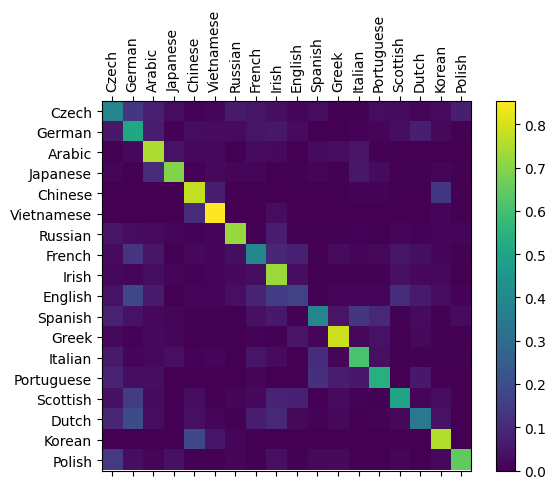

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    language, name, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_languages.index(language)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_languages, rotation=90)
ax.set_yticklabels([''] + all_languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(name_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            lang_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_languages[lang_index]))
            predictions.append([value, all_languages[lang_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.52) Czech
(-1.12) Russian
(-3.19) English

> Jackson
(-0.44) Scottish
(-1.54) English
(-3.37) Czech

> Satoshi
(-0.76) Italian
(-1.09) Japanese
(-2.38) Arabic
